In [ ]:
from functools import partial

import matplotlib.pyplot as plt
import optuna
import seaborn as sns
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

from NEExT.collections import EgonetCollection
from NEExT.io import GraphIO
from NEExT.outliers import CosineOutlierDetector, OutlierDataset, LGBMOutlier

%reload_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
from typing import Dict


def semi_supervised_set(
    features_df: pd.DataFrame,
    hide_frac: Dict[int, float],
    col: str = "is_outlier",
    seed: int = 42,
):
    """Fot a graph with known labels randomly hide a fraction of labels"""
    _features_df = features_df.copy()
    np.random.seed(seed)

    for _cls, frac in hide_frac.items():
        if frac == 0:
            continue
        mask = _features_df[col] == _cls
        drop_indices = np.random.choice(_features_df[mask].index, size=int(len(_features_df[mask]) * frac), replace=False)
        _features_df.loc[drop_indices, col] = -1

    return _features_df


def load_abcdo_data(
    name: str = "abcdo_data_1000_200_0.1",
    hide_frac: Dict[int, float] = {0: 1, 1: 1},
):
    path = f"https://raw.githubusercontent.com/CptQuak/graph_data/refs/heads/main/simulated/{name}/"

    edges_df = pd.read_csv(path + 'edges.csv')
    mapping_df = pd.read_csv(path + 'graph_mapping.csv')
    features_df = pd.read_csv(path + 'features.csv').sort_values("node_id").reset_index(drop=True)
    ground_truth_df = features_df[["node_id", "is_outlier"]].rename(columns={"node_id": "graph_id"}).copy()

    features_df = semi_supervised_set(features_df, hide_frac)
    return edges_df, mapping_df, features_df, ground_truth_df


def load_pygod_data(
    name: str = "gen_100",
    outlier_mode: str = "any",
    hide_frac: Dict[int, float] = {0: 1, 1: 1},
):
    from pygod.utils import load_data

    dataset = load_data(name)

    if outlier_mode == "any":
        y_target = np.where(dataset.y > 0, 1, 0)
    elif outlier_mode == "structural":
        y_target = np.where((dataset.y == 2) | (dataset.y == 3), 1, 0)
    elif outlier_mode == "contextual":
        y_target = np.where((dataset.y == 1) | (dataset.y == 3), 1, 0)

    edges_df = pd.DataFrame(dataset.edge_index.T)
    edges_df.columns = ["src_node_id", "dest_node_id"]

    features_df = pd.DataFrame()
    features_df = pd.DataFrame(dataset.x)
    features_df.columns = [f'x_{i}' for i in range(dataset.x.shape[1])]

    features_df["is_outlier"] = y_target
    features_df.insert(0, "node_id", list(range(len(features_df))))

    ground_truth_df = pd.DataFrame()
    ground_truth_df["graph_id"] = list(range(len(features_df)))
    ground_truth_df["is_outlier"] = y_target

    features_df = semi_supervised_set(features_df, hide_frac)

    mapping_df = pd.DataFrame()
    mapping_df["node_id"] = list(range(len(features_df)))
    mapping_df["graph_id"] = 0

    return edges_df, mapping_df, features_df, ground_truth_df


In [ ]:
from typing import List

from NEExT.builders import EmbeddingBuilder
from NEExT.features import NodeFeatures, StructuralNodeFeatures


def build_features(
    egonet_collection: EgonetCollection,
    feature_vector_length: int,
    feature_list: List[str],
):
    structural_node_features = StructuralNodeFeatures(
        graph_collection=egonet_collection,
        feature_list=["all"],
        feature_vector_length=feature_vector_length,
        n_jobs=1,
        show_progress=False,
    )
    node_features = NodeFeatures(
        egonet_collection,
        feature_list=feature_list,
        show_progress=False,
    )
    structural_features = structural_node_features.compute()
    features = node_features.compute()
    return structural_features, features


def build_embeddings(
    egonet_collection: EgonetCollection,
    structural_features: List[str],
    features: List[str],
    strategy: str,
    structural_embedding_dimension: int,
    feature_embedding_dimension: int,
    embedding_algorithm: str = 'approx_wasserstein',
):
    emb_builder = EmbeddingBuilder(
        egonet_collection,
        strategy=strategy,
        structural_features=structural_features,
        features=features,
    )
    embeddings = emb_builder.compute(structural_embedding_dimension, feature_embedding_dimension, embedding_algorithm=embedding_algorithm)
    return embeddings


In [ ]:
import pandas as pd
from sklearn.base import BaseEstimator


def score_unlabeled_gt(
    dataset: OutlierDataset,
    detector: BaseEstimator,
    ground_truth_df: pd.DataFrame = None,
):
    if ground_truth_df is not None:
        ground_truth_df = ground_truth_df.sort_values("graph_id")
        out = predict_full_df(detector, dataset.graph_id, dataset.X)
        bl_acc = roc_auc_score(ground_truth_df["is_outlier"], out["pred"])
    else:
        out = predict_full_df(detector, dataset.labeled_graphs, dataset.X_labeled)
        bl_acc = roc_auc_score(dataset.y_labeled, out["pred"])
    return out, bl_acc


def predict_full_df(detector: BaseEstimator, unlabeled: np.ndarray, X: np.ndarray):
    df = []

    probs = detector.predict_proba(X)[:, 1]
    preds = detector.predict(X)

    df = pd.DataFrame({"graph_id": unlabeled, "prob": probs, "pred": preds}).sort_values("graph_id")
    return df


In [2]:
graph_io = GraphIO()
hide_frac = {0: 0.8, 1: 0.8}

edges_df, mapping_df, features_df, ground_truth_df = load_pygod_data(hide_frac=hide_frac)
# edges_df, mapping_df, features_df, ground_truth_df = load_abcdo_data(hide_frac=hide_frac)

graph_data = {
    "target": "is_outlier",
    "skip_features": [],
    "feature_list": [],
    # "feature_list": [i for i in features_df.columns[1:-1]],
}

/home/quak/miniconda3/envs/neext/lib/python3.11/site-packages/pygod/utils/utility.py:173: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


In [3]:
graph_collection = graph_io.load_from_dfs(
    edges_df=edges_df,
    node_graph_df=mapping_df,
    node_features_df=features_df,
    graph_type="igraph",
    filter_largest_component=False,
)
subgraph_collection = EgonetCollection()
subgraph_collection.create_egonets_from_graphs(
    graph_collection=graph_collection,
    egonet_target=graph_data["target"],
    egonet_algorithm="k_hop_egonet",
    skip_features=graph_data["skip_features"],
    max_hop_length=1,
)
structural_features, features = build_features(subgraph_collection, feature_vector_length=5, feature_list=graph_data["feature_list"])

In [4]:
embeddings = build_embeddings(
    subgraph_collection,
    structural_features,
    features,
    strategy="structural_embedding",
    structural_embedding_dimension=5,
    feature_embedding_dimension=5,
    embedding_algorithm="approx_wasserstein",
    # approx_wasserstein, wasserstein, sinkhornvectorizer
)
dataset = OutlierDataset(subgraph_collection, embeddings, standardize=False)

In [ ]:
from functools import partial

import numpy as np
import optuna
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

from experiment_utils.models import score_unlabeled_gt
from NEExT.outliers import CosineOutlierDetector, LGBMOutlier, OutlierDataset


def objective(trial: optuna.Trial, model: str, dataset: OutlierDataset):
    if model == "cosine":
        top_k = trial.suggest_int("top_k", 1, 20)
        detector = CosineOutlierDetector(top_k=top_k)
    elif model == "knn":
        n_neighbors = trial.suggest_int("n_neighbors", 1, 50)
        detector = KNeighborsClassifier(n_neighbors=n_neighbors)
    elif model == "lgbm":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 1, 75),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 10),
            "num_leaves": trial.suggest_int("num_leaves", 10, 100),
            "max_depth": trial.suggest_int("max_depth", 1, 100),
            "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
            "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e1, log=True),
            "reg_alpha": trial.suggest_float("learning_rate", 1e-5, 1e1, log=True),
            "reg_lambda": trial.suggest_float("learning_rate", 1e-5, 1e1, log=True),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1),
        }
        detector = LGBMOutlier(**params)

    metric = cross_val_score(
        detector,
        dataset.X_labeled,
        dataset.y_labeled,
        cv=StratifiedKFold(min(5, int(np.sum(dataset.y_labeled)))),
        n_jobs=-1,
        scoring=make_scorer(roc_auc_score),
    )
    return np.nanmean(metric)


def supervised_eval(model, ground_truth_df, dataset):
    study = optuna.create_study(direction="maximize")
    study.optimize(partial(objective, model=model, dataset=dataset), n_trials=50, n_jobs=4)

    if model == "cosine":
        detector = CosineOutlierDetector(**study.best_params)
    elif model == "knn":
        detector = KNeighborsClassifier(**study.best_params)
    elif model == "lgbm":
        detector = LGBMOutlier(**study.best_params)

    detector.fit(dataset.X_labeled, dataset.y_labeled)
    out_df, score = score_unlabeled_gt(dataset, detector, ground_truth_df)
    return out_df, score

model = "cosine"
out_df, score = supervised_eval(model, ground_truth_df, dataset)
score

[I 2025-03-30 20:35:39,739] A new study created in memory with name: no-name-58f30af1-aca9-4d4c-9a20-987340f04f22


[I 2025-03-30 20:35:44,657] Trial 2 finished with value: 0.5 and parameters: {'top_k': 2}. Best is trial 2 with value: 0.5.
[I 2025-03-30 20:35:44,731] Trial 4 finished with value: 0.5 and parameters: {'top_k': 4}. Best is trial 2 with value: 0.5.
[I 2025-03-30 20:35:44,786] Trial 5 finished with value: 0.5 and parameters: {'top_k': 14}. Best is trial 2 with value: 0.5.
[I 2025-03-30 20:35:44,828] Trial 6 finished with value: 0.5 and parameters: {'top_k': 10}. Best is trial 2 with value: 0.5.
[I 2025-03-30 20:35:44,865] Trial 7 finished with value: 0.5 and parameters: {'top_k': 2}. Best is trial 2 with value: 0.5.
[I 2025-03-30 20:35:44,914] Trial 8 finished with value: 0.5 and parameters: {'top_k': 18}. Best is trial 2 with value: 0.5.
[I 2025-03-30 20:35:44,965] Trial 9 finished with value: 0.5 and parameters: {'top_k': 20}. Best is trial 2 with value: 0.5.
[I 2025-03-30 20:35:45,022] Trial 10 finished with value: 0.5 and parameters: {'top_k': 13}. Best is trial 2 with value: 0.5.
[I

0.5277777777777778

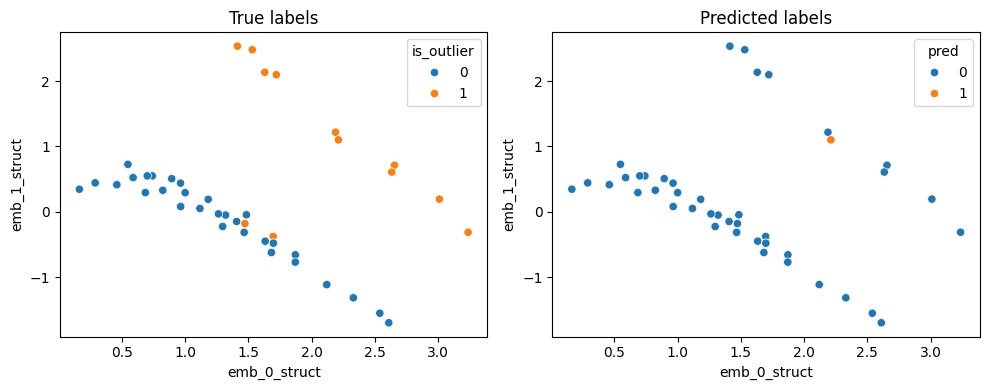

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(x=embeddings.embeddings_df.iloc[:, 1], y=embeddings.embeddings_df.iloc[:, 2], hue=ground_truth_df["is_outlier"], ax=ax[0])
ax[0].set_title("True labels")

sns.scatterplot(x=embeddings.embeddings_df.iloc[:, 1], y=embeddings.embeddings_df.iloc[:, 2], hue=out_df["pred"], ax=ax[1])
ax[1].set_title("Predicted labels")

fig.tight_layout()